In [1]:
## Code to replicate the BLP results from : https://github.com/chrisconlon/blp-demand
## Sophie Bindslev, 10 March 2025

import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import numpy.linalg as la

# userwritten modules
import linear 
import logit_agg_ex_post as logit_agg

%load_ext autoreload
%autoreload 2

In [2]:
# Plan

# Part 1: Vanilla Logit
# estimate vanilla logit on market shares using ols and then iv
# statistics of interest: elasticities, welfare measure, market shares
# estimate vanilla logit on market shares using fixed point iteration - show that it converges immediately

# Part 2: Random Coefficients Logit - buidling blocks
# introduce the building blocks for random coefficients logit


# Part 3: Random Coefficients Logit - put it all together
# inner loop : construct the objective function

# 1. get mean utilities, delta, using fixed point iteration and ccps
# 2. linear projection of deltas on Xs to get xis (residuals)
# 3. form the gmm objective function by multiplying the xis with the instruments 

# outer loop : search over nonlinear parameters: minimize gmm objective function wrt nonlinear parameters

Motivator: in a world where we have market share data rather than individual level chocie data, can we still hope to estimate a logit model? yes! 

# The Random Coefficients Logit Model
## Individual level utility
Random Utility to individual, $i$, from each option, $j$, in market, $t$:
$$
    u_{ijt} = \mathbf{x}_{jt}\boldsymbol{\beta}_i + \alpha_{i} p_{jt} + \xi_{jt} + \varepsilon_{ijt}, \quad \varepsilon_{ijt}\sim\text{IID Extreme Value Type I}\\
$$

Normalise outside option: 
$$
    u_{i0t} = \varepsilon_{i0t}
$$

Decomposing the Random coefficients into their common and individual-specific parts 
$$    \boldsymbol\beta_i^{(k)} =\beta_{0}^{(k)} + \sigma_{\beta}^{(k)}\nu_i^{(k)}\\
\alpha_i =\alpha_{0} + \sigma_{\alpha}\nu_i\\

$$

Can re-write individual utility as
$$    
    u_{ijt} = \delta_{jt}+\mu_{ijt}+ \varepsilon_{ijt}\\
    \delta_{jt} = \mathbf{x}_{jt}\boldsymbol{\beta}_0 + \alpha_0 p_{jt} + \xi_{jt}\\
    \mu_{ijt} + \varepsilon_{ijt} = \mathbf{x}_{jt}(\boldsymbol{{\sigma}}_{\beta}\boldsymbol{\nu}_i) + \varepsilon_{ijt}
$$

where $\boldsymbol{\nu}_i\sim N(0,\boldsymbol{\Sigma})$ may be e.g., independent or correlated normally distributed.

Using the the idiosyncratic errors are IID EV1, obtain individual level choice probabilities:
$$    
P_{ijt} = \int_{\varepsilon} I(\varepsilon_{ijt}-\varepsilon_{iht}>\delta_{ht}+\mu_{iht}-\delta_{jt}-\mu_{ijt}\mid j\neq h \in J_t)f(\boldsymbol{\varepsilon}_{it})d\boldsymbol{\varepsilon}_{it}\\
=\frac{\exp(\delta_{jt}+\mu_{ijt})}{1+\sum^{J_t}_h\exp(\delta_{ht}+\mu_{iht})}
$$


## Market Shares
From these individual choice probabilities we can obtain overall market shares by aggregating over individuals in each market: 
$$
    s_{jt} = \int_{i} \frac{\exp(\delta_{jt}+\mu_{ijt})}{1+\sum^{J_t}_h\exp(\delta_{ht}+\mu_{ijt})}f(\boldsymbol{\mu}_{it}|\boldsymbol{\theta}_{non})d\boldsymbol{\mu}_{it}.
$$
Effectively this integrates over all individuals' choice probabilities, assigning weights to each probability according to the mixing distribution, $f(\boldsymbol{\mu}_{it}|\boldsymbol{\theta}_{non})$. This distribution is parameterized by $\boldsymbol{\theta}_{non}$.



## Data: Aggregated data

In [3]:
# load the data
dtable = pd.read_csv('table1.csv')

In [4]:
# take a look at the data - market shares for each product at a given point in time as well as product attributes: prices etc.
dtable.head()

,mktid,prodid,price,sjt,s0t,x1_1,x1_2,x1_3,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_10,delta,firmid
0,1,1,5.894105,0.002877,0.258113,1,0.638778,0.792877,0.437815,0.478248,0.397455,0.400379,0.913802,0.893741,0.835034,0.798772,0.174012,0.191481,-4.496703,1
1,1,2,4.076156,0.002663,0.258113,1,0.223674,0.826898,0.441967,0.477908,0.438965,0.396977,0.074285,0.816243,0.005518,0.666252,0.194008,0.189718,-4.573763,1
2,1,3,4.076300,0.000426,0.258113,1,0.169340,0.159173,0.442510,0.484585,0.444399,0.463750,0.471507,0.947423,0.222319,0.897611,0.196651,0.224726,-6.406749,1
3,1,4,3.462267,0.001733,0.258113,1,0.390939,0.014996,0.440294,0.486027,0.422239,0.478167,0.360546,0.240320,0.129993,0.057754,0.185909,0.232402,-5.003689,1
4,1,5,4.087225,0.003498,0.258113,1,0.459011,0.455759,0.439613,0.481619,0.415432,0.434091,0.305593,0.579701,0.093387,0.336053,0.182629,0.209067,-4.301152,1


In [5]:
dtable.columns # columns headers

Index(['mktid', 'prodid', 'price', 'sjt', 's0t', 'x1_1', 'x1_2', 'x1_3', 'z_1',
       'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'z_10', 'delta',
       'firmid'],
      dtype='object')

In [6]:
x1s = ['x1_1', 'x1_2', 'x1_3']
zs = [ 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8',
       'z_9', 'z_10']

In [7]:
sjt = dtable['sjt'].to_numpy().reshape(-1,1)
s0t = dtable['s0t'].to_numpy().reshape(-1,1)

# Part 1: Vanilla Logit
Without random taste heterogeneity this boils down to a standard logit model which can be estimated via ordinary least squares using aggregate market share data. To see this, consider the market share expression above when there is no unobserved taste heterogeneity. In that case, the distribution $f(\boldsymbol{\mu}_{it})$ is degenerate. In the above specification this is equivalent to $\{\boldsymbol{\sigma}_{\beta},\sigma_{\alpha}\}=\textbf{0}_{K+1}$ and we get (we can set $\mu_{ijt}=0$).
$$    
s_{jt} = \frac{\exp(\delta_{jt})}{1+\sum^{J_t}_h\exp(\delta_{ht})}.
$$

Taking logs yields
$$    
\log(s_{jt})= \log(\frac{\exp(\delta_{jt})}{1+\sum^{J_t}_h\exp(\delta_{ht})})=\log(\exp(\delta_{jt}))-\log(1+(\sum^{J_t}_h\exp(\delta_{ht})))\\
    \log(s_{0t})= \log(\frac{\exp(\delta_{0t})}{1+\sum^{J_t}_h\exp(\delta_{ht})})=\log(\exp(0))-\log(1+(\sum^{J_t}_h\exp(\delta_{ht})))\\
    =-\log(1+(\sum^{J_t}_h\exp(\delta_{ht})))\nonumber.
$$

Subtracting the outside good from other goods:

$$    \log(s_{jt}) - \log(s_{0t})\nonumber \\
    =\log(\exp(\delta_{jt}))-\log(1+(\sum^{J_t}_h\exp(\delta_{ht})))-(-\log(1+(\sum^{J_t}_h\exp(\delta_{ht})))) \\
    = \log(\exp(\delta_{jt})) = \delta_{jt}.
$$
Finally, using the representation of common utility:
$$    \log(s_{jt}) - \log(s_{0t}) = \delta_{jt} = \mathbf{x}_{jt}\beta_0 + \alpha_0 p_{jt} + \xi_{jt}
$$

That is, we can estimate the parameters, $\boldsymbol{\beta},\alpha$, via a linear projection of the log difference in market shares relative to the outside good, $\log(s_{jt}) - \log(s_{0t})$, onto product attributes, $ \mathbf{x}_{jt} $.

### 1.1 Estimation
Estimate the vanilla logit model using the data you loaded above, taking logs and differencing

In [8]:
deltas = np.log(sjt) - np.log(s0t) # Fill in 
X = dtable[['price']+x1s].to_numpy() # Fill in
T = dtable.mktid.nunique() # Fill in

In [9]:
res = linear.estimate(deltas,X, T=T,robust_se=True)
linear.print_table(labels = (('logdiff'),(['price']+x1s)),results=res)

Results
Dependent variable: logdiff

            Beta          Se    t-values
-----  ---------  ----------  ----------
price  -0.838357  0.00328081    -255.533
x1_1   -4.24195   0.0145349     -291.847
x1_2    5.57784   0.00931201     598.994
x1_3    1.92143   0.00779516     246.491
R² = 0.972
σ² = 0.066


Your results should look like this:


Results <br>
Dependent variable: logdiff <br>

|                |    Beta |     Se |   t-values |
|----------------|---------|--------|------------|
| price       | -0.838357 | 0.00328081 |    -255.533 |
| x1_1          | -4.24195 | 0.0145349 |    -291.847 |
| x1_2       |  5.57784 | 0.00931201 |     598.994 |
| x1_3      |  1.92143 | 0.00779516 |    246.491 |
R² = 0.972 <br>
σ² = 0.066

We suspect that price is not exogenous to demand and so might want to use an instrument for price.

Estimate the same model but with an IV-approach. Hint: you can give linear.estimate instruments, Z, in which case it will perform this step for you.

In [10]:
Z = dtable[x1s + zs].to_numpy() # Fill in

res_iv = linear.estimate(deltas,X, Z, T=T,robust_se=True) # nb standard errors not corrected for iv estimation
linear.print_table(labels = (('logdiff'),(['price']+x1s)),results=res_iv,title='Results - IV estimation')

Results - IV estimation
Dependent variable: logdiff

            Beta         Se    t-values
-----  ---------  ---------  ----------
price  -0.998835  0.016594     -60.1924
x1_1   -3.64362   0.0624751    -58.3212
x1_2    5.72642   0.0186231    307.491
x1_3    2.07995   0.0183874    113.118
R² = 0.968
σ² = 0.077


Your results should look like this:


Results - IV estimation <br>
Dependent variable: logdiff <br>

|                |    Beta |     Se |   t-values |
|----------------|---------|--------|------------|
| price       | -0.998835   | 0.016594 |    -60.1924 |
| x1_1          | -3.64362    | 0.0624751  |    -58.3212 |
| x1_2       |  5.72642    | 0.0186231 |     307.491 |
| x1_3      |  2.07995    | 0.0183874 |    113.118 |
R² = 0.968 <br>
σ² = 0.077

### 1.2 Predicted Market Shares
Compute the model implied market shares.

In the vanilla logit model we have
$$    
s_{jt} = \frac{\exp(\delta_{jt})}{1+\sum^{J_t}_h\exp(\delta_{ht})}.
$$
where 
$$    
    \delta_{jt} =  \log(s_{jt}) - \log(s_{0t}) \\
$$


In [11]:
# get mkt id
mktids = dtable['mktid'].to_numpy()

# get choice probabilities given deltas, using the choice_probs function in logit_agg.py <--- you will need to fill this out for the code below to work

# initialise
ccp_pred = np.zeros_like(deltas)

# loop over markets
for m in np.unique(mktids):
    delta_m = deltas[mktids==m]
    ccp_pred[mktids==m],_ = logit_agg.singlechoiceprob(delta_m) # you will need to fill in the missing part of this function in the logit_agg.py file

Compare predicted and actual market shares - does what you see make sense?

In [12]:
print(sjt.flatten()) 
print(ccp_pred.flatten())

[0.00287685 0.00266349 0.00042598 ... 0.0310292  0.00123969 0.00100363]
[0.00287685 0.00266349 0.00042598 ... 0.0310292  0.00123969 0.00100363]


### 1.3 Statistics of interest: elasticities, compensating variation
Using your estimation results compute elasticities and compensating variation. 
Fill out the functions for this in logit_agg.py file.

### Price Elasticities: Own- and Cross-products

The main parameters describing substitution patterns are elasticities and diversion ratios. In the case of vanilla logit these take the form:
$$    \eta_{jkt} = \frac{\partial s_{jt}}{\partial p_{kt}}\frac{p_{kt}}{s_{jt}}=\begin{cases}
        \alpha_0 p_{jt}(1-s_{jt}) \quad \text{if} \quad j=k\\
        -\alpha_0 p_{kt}s_{kt} \quad \text{otherwise}
    \end{cases}$$


In [13]:
# pull out the common marginal disutility of price, alpha0
k_price = 0
alpha0 = res['b_hat'][k_price] # what happens if you pick alpha0 from the model without instrumenting ?
alpha0_iv = res_iv['b_hat'][k_price] # what happens if you pick alpha0 from the model with instrumenting instead?

ccp_pred = ccp_pred.flatten()


# pull out price
price = dtable['price'].to_numpy()

# combine the above to compute the elasticities
elast_own =  alpha0 * price * ( 1 - ccp_pred ) # fill in
elast_cross = - alpha0 * price * ccp_pred # fill in 

elast_own_iv =  alpha0_iv * price * ( 1 - ccp_pred ) # fill in 
elast_cross_iv = - alpha0_iv * price * ccp_pred # fill in

print('own price elasticity',elast_own)
print('cross price elasticities',elast_cross)

own price elasticity [-4.9271497  -3.40817301 -3.4159392  ... -3.45505511 -2.69633993
 -3.9604681 ]
cross price elasticities [0.01421555 0.00910186 0.00145576 ... 0.1106407  0.00334676 0.00397885]


In [14]:
# pull out the mean elasticities for each product (across markets)
prodids = dtable.prodid.to_numpy()
J = len(np.unique(prodids))
eown = np.zeros(J)
ecross = np.zeros(J)
eown_iv = np.zeros(J)
ecross_iv = np.zeros(J)

for j,prodid in enumerate(np.unique(prodids)):
    eown[j] = elast_own[prodids==prodid].mean() # average over all markets for a given product
    ecross[j] = elast_cross[prodids==prodid].mean()# average over all markets for a given product
    eown_iv[j] = elast_own_iv[prodids==prodid].mean() # average over all markets for a given product
    ecross_iv[j] = elast_cross_iv[prodids==prodid].mean()# average over all markets for a given product

In [15]:
eown[1] # product 2's mean own price elasticity across all markets

-3.81274186908149

In [16]:
ecross[1] # how all other products respond to a 1% price increase in product 2 on average across all markets

0.034724121798667885

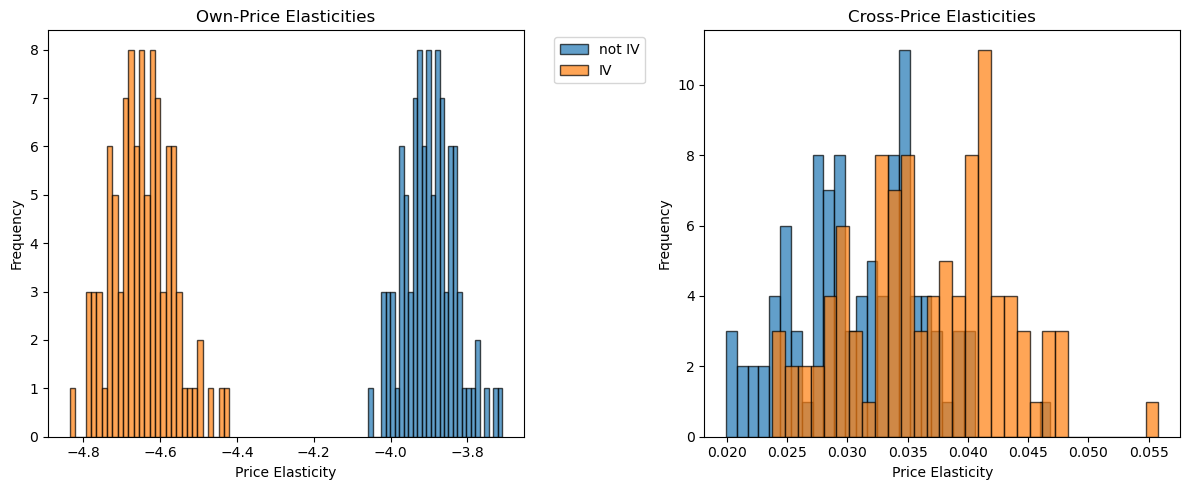

In [17]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot histogram for own-price elasticities
axes[0].hist(eown, bins=30, edgecolor='black', alpha=0.7,label='not IV')
axes[0].hist(eown_iv, bins=30, edgecolor='black', alpha=0.7,label='IV')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_title("Own-Price Elasticities")
axes[0].set_xlabel("Price Elasticity")
axes[0].set_ylabel("Frequency")

# Plot histogram for cross-price elasticities
axes[1].hist(ecross, bins=30, edgecolor='black', alpha=0.7,label='not IV')
axes[1].hist(ecross_iv, bins=30, edgecolor='black', alpha=0.7,label='IV')
axes[1].set_title("Cross-Price Elasticities")
axes[1].set_xlabel("Price Elasticity")
axes[1].set_ylabel("Frequency")

# Adjust layout and show plot
plt.tight_layout()  # Ensures plots don't overlap
plt.show()

### Compensating Variation

You can compute the compensating variation of a counterfactual environment using the result that the $E\max(u)$ when $u=v+\epsilon,\epsilon \sim EV1 $ is given by
$$
E\max_j(u_{ij}) = \log(\sum^{J_t}_h\exp(\delta_{ht}))+\gamma
$$
where $\gamma$ is the Euler constant. 

If we have a price regressor and its estimated coefficient is $\alpha_0$, then $1/\alpha_0$ converts utils into money. 

We can therefore use the following welfare measure (in monetary terms) of moving from $\{\delta^{base}_{ht}\}$ to $\{\delta^{new}_{ht}\}$:
$$
CV = \frac{1}{\alpha_0} \log(\sum^{J_t}_h\exp(\delta^{new}_{ht}))+\gamma - (\frac{1}{\alpha_0} \log(\sum^{J_t}_h\exp(\delta^{base}_{ht}))+\gamma ) = \frac{1}{\alpha_0} (\log(\sum^{J_t}_h\exp(\delta^{new}_{ht})) - \log(\sum^{J_t}_h\exp(\delta^{base}_{ht})))
$$

In [18]:
def compensating_var(x_base,x_new,res,k_price = 0):
    alpha0 = res['b_hat'][k_price] 

    # compute the compensating variation
    delta_base = x_base@res['b_hat']
    logsum_base = np.log(np.sum(np.exp(delta_base))) # emax under baseline environment

    delta_new = x_new@res['b_hat']
    logsum_new = np.log(np.sum(np.exp(delta_new))) # emax under counterfactual environment
    
    cv = 1/alpha0 * ( logsum_new - logsum_base ) 
    return cv

In [19]:
x_base = X.copy()
x_new = X.copy()
x_new[:,0] = x_new[:,0] * 1.01 # 1% price increase for all products

In [20]:
compensating_var(x_base,x_new,res,k_price = 0)

array([0.04696151])

In [21]:
compensating_var(x_base,x_new,res_iv,k_price = 0)

array([0.04634562])

# Part 2: Building blocks of Random Coefficients Logit

With random coefficients we're back to the following expression for market shares
$$
    s_{jt} = \int_{i} \frac{\exp(\delta_{jt}+\mu_{ijt})}{1+\sum^{J_t}_h\exp(\delta_{ht}+\mu_{ijt})}f(\boldsymbol{\mu}_{it}|\boldsymbol{\theta}_{non})d\boldsymbol{\mu}_{it}.
$$

We can no longer take logs, difference and use a linear projection of $\log(s_{jt}) - \log(s_{0t})$, onto product attributes, $ \mathbf{x}_{jt} $ to recover the $\boldsymbol{\beta}$ due to the nonlinearity introduced by $f(\boldsymbol{\mu}_{it}|\boldsymbol{\theta}_{non})$. But we can do something similar. BLP 1995 show that the following relation is a contraction mapping and that the set of common utilities, $\boldsymbol{\delta}_t$, are the fixed point of this contraction:
$$    \boldsymbol{\delta}_t^{(k)}(\boldsymbol{\theta}_{non}) = \boldsymbol{\delta}_t^{(k-1)}(\boldsymbol{\theta}_{non}) + \log(\mathfrak{s}_{jt})-\log(s_j(\boldsymbol{\delta}_t^{(k-1)},\boldsymbol{\theta}_{non})).
$$
Here $\mathfrak{s}_{jt}$ are observed market shares, whilst $s_j(\boldsymbol{\delta}_t^{(k-1)},\boldsymbol{\theta}_{non})$ are predicted market shares.

### 2.1 predicted market shares

To integrate out the unobserved heterogeneity in $\boldsymbol{\mu}$ we use sparse grids weights and nodes from http://www.sparse-grids.de/. This is a numerical integration method that essentially replaces and approximates the continuous distribution in $f(\boldsymbol{\mu}_{it}|\boldsymbol{\theta}_{non})$ with a discrete one:

$$
    s_{jt} = \int_{i} \frac{\exp(\delta_{jt}+\mu_{ijt})}{1+\sum^{J_t}_h\exp(\delta_{ht}+\mu_{ijt})}f(\boldsymbol{\mu}_{it}|\boldsymbol{\theta}_{non})d\boldsymbol{\mu}_{it} 
    = \int_{i} \frac{\exp(\delta_{jt}+\mathbf{x}_{jt}\boldsymbol{{\sigma}}_{\beta}\boldsymbol{\nu}_i)}{1+\sum^{J_t}_h\exp(\delta_{ht}+\mathbf{x}_{jt}\boldsymbol{{\sigma}}_{\beta}\boldsymbol{\nu}_i)}f(\boldsymbol{\nu}_i)d\boldsymbol{\nu}_{i} \\
    \approx\sum^{\Iota}_{\iota} w_{\iota} \frac{\exp(\delta_{jt}+ \mathbf{x}_{jt}\boldsymbol{{\sigma}}_{\beta}v_{\iota})}{1+\sum^{J_t}_h\exp(\delta_{ht}+ \mathbf{x}_{jt}\boldsymbol{{\sigma}}_{\beta}v_{\iota})}
$$

where $w_{\iota},v_{\iota}$ are the weights and nodes, respectively.

Please note, here we have only allowed for random coefficients on the exogenous explanatory variables $\mathbf{x}_{jt}$, NOT on price, the endogenous variable. So relative to above we have $\sigma_{\alpha}=0$


In [22]:
# load draws needed for random coefficients
draws = pd.read_csv('draws.csv')

# unpack draws 
v = np.vstack((draws.v_1,draws.v_2)).T # nodes
w = np.array(draws.w).reshape(-1,1) # weights

In [23]:
# initialize the nonlinear parameters and pull out the corresponding variables
theta0 = np.array([0.5,0.5])
X_random = dtable[['x1_2', 'x1_3']].to_numpy() # the variables that get random coefficients. NOT the price variable

In [24]:
# compute predicted market shares for initial guess of theta and delta
# initialise
ccp_test = np.zeros_like(deltas)

# loop over markets
for m in np.unique(mktids):
    delta_m = deltas[mktids==m]
    x_random_m = X_random[mktids==m]

    ccp_test[mktids==m],_ = logit_agg.singlechoiceprob(delta_m,theta0,w,v,x_random_m) # now you need to fill in the missing part of 
    # this function in the logit_agg.py file for the random coefficient version of this to work

ccp_test = ccp_test.flatten()

In [25]:
ccp_test # when theta = [[0,0]], ccp should be the same as ccp_pred from vanilla logit

array([0.00281735, 0.00265445, 0.00042492, ..., 0.03024085, 0.00125071,
       0.00099494])

In [26]:
ccp_pred # vanilla logit ccp

array([0.00287685, 0.00266349, 0.00042598, ..., 0.0310292 , 0.00123969,
       0.00100363])

### 2.2 fixed point algo

We now solve for the mean utilities, $\boldsymbol{\delta}_t$, by iterating on the contraction mapping which the $\boldsymbol{\delta}_t$ are the fixed point of, as established by BLP in 1995:

$$    \boldsymbol{\delta}_t^{(k)}(\boldsymbol{\theta}_{non}) = \boldsymbol{\delta}_t^{(k-1)}(\boldsymbol{\theta}_{non}) + \log(\mathfrak{s}_{jt})-\log(s_j(\boldsymbol{\delta}_t^{(k-1)},\boldsymbol{\theta}_{non})).
$$
Here $\mathfrak{s}_{jt}$ are observed market shares, whilst $s_j(\boldsymbol{\delta}_t^{(k-1)},\boldsymbol{\theta}_{non})$ are predicted market shares.

In [27]:
# fill out the missing part of the function called fixedpoint below

def fixedpoint(deltas,ccp_data,mktids,theta=None,w=None,v=None,x_random=None):
    
    dhat = np.zeros(len(deltas)).reshape(-1,1)

    for m in np.unique(mktids):
        delta_m = deltas[mktids==m]#.flatten()
        ccp_data_m = ccp_data[mktids==m] 

        if x_random is not None:
            x_random_m = x_random[mktids==m]
        
        else:
            x_random_m = None

        f_m = lambda delta: delta + np.log(ccp_data_m) - np.log(logit_agg.singlechoiceprob(delta,theta,w,v,x_random_m)[0]) # fill in BLP contraction - separately for each market, m  
        
        dhat[mktids==m] = logit_agg.iteration(f_m,delta_m) # call iterator on f_m

    return dhat

In [28]:
# solve the fixed point problem to get the mean utilities, delta
theta0 = np.array([0.0,0.0])
delta0 = np.log(sjt)-np.log(s0t)
dhat = fixedpoint(delta0,sjt,mktids,theta0,w,v,X_random)

In [29]:
dhat.flatten() # mean utilities

array([-4.4967032 , -4.57376255, -6.40674922, ..., -1.81146061,
       -5.03153199, -5.24276286])

### 2.3 linear parameters, $\boldsymbol{\beta}$

In [30]:
# recover the linear paramets, beta, from a linear projection of delta on Xs
res_2 = linear.estimate(dhat.reshape(-1,1), X,Z,robust_se=True,T=T)
linear.print_table(labels = (('delta'),(['price']+x1s)),results=res_2)

Results
Dependent variable: delta

            Beta         Se    t-values
-----  ---------  ---------  ----------
price  -0.998835  0.016594     -60.1924
x1_1   -3.64362   0.0624751    -58.3212
x1_2    5.72642   0.0186231    307.491
x1_3    2.07995   0.0183874    113.118
R² = 0.968
σ² = 0.077


Compare to the vanilla logit case you had before - are the results the same? why/why not?

In [31]:
linear.print_table(labels = (('logdiff'),(['price']+x1s)),results=res_iv)

Results
Dependent variable: logdiff

            Beta         Se    t-values
-----  ---------  ---------  ----------
price  -0.998835  0.016594     -60.1924
x1_1   -3.64362   0.0624751    -58.3212
x1_2    5.72642   0.0186231    307.491
x1_3    2.07995   0.0183874    113.118
R² = 0.968
σ² = 0.077


In [32]:
# now re-run the iteration but with nonlinear parameters
# solve the fixed point problem to get the mean utilities, delta

theta1 = np.array([0.5,0.5])

# deltas when there are random coefficients
dhat_random = fixedpoint(deltas ,sjt,mktids,theta1,w,v,X_random)

# linear projection of deltas onto explanatory variables
res_random = linear.estimate(dhat_random.reshape(-1,1), X,Z,robust_se=True,T=T) 
linear.print_table(labels = (('delta'),(['price']+x1s)),results=res_random)

Results
Dependent variable: delta

            Beta         Se    t-values
-----  ---------  ---------  ----------
price  -0.999243  0.0165923    -60.2233
x1_1   -3.60438   0.0624473    -57.7187
x1_2    5.7609    0.0184411    312.395
x1_3    2.07019   0.0183045    113.097
R² = 0.969
σ² = 0.075


Your results should look like this:


Results <br>
Dependent variable: delta_random <br>

|                |    Beta |     Se |   t-values |
|----------------|---------|--------|------------|
| price       | -0.999243     | 0.0165923         |    -60.2233 |
| x1_1          | -3.60438        | 0.0624473              |    -57.7187 |
| x1_2       |  5.7609         | 0.0184411              |     312.395 |
| x1_3      |  2.07019         | 0.0183045            |    113.097 |
R² = 0.969 <br>
σ² = 0.075

Are the results the same as in vanilla logit? why/why not?

In [33]:
# let's print the vanilla logit, iv, estimation results again to compare
linear.print_table(labels = (('delta'),(['price']+x1s)),results=res_iv)

Results
Dependent variable: delta

            Beta         Se    t-values
-----  ---------  ---------  ----------
price  -0.998835  0.016594     -60.1924
x1_1   -3.64362   0.0624751    -58.3212
x1_2    5.72642   0.0186231    307.491
x1_3    2.07995   0.0183874    113.118
R² = 0.968
σ² = 0.077


### 2.4 objective function

We now use the residuals from the IV regression, $\hat{\xi}_{jt}$, to compute the criterion function:
$$    
g(\boldsymbol{\theta}_{non}) =\frac{1}{N} \sum_t\sum_j \hat{\xi}_{jt}\mathbf{Z}_{jt}, \quad N=\sum_t J_t.
$$
This criterion function is based on a set of moments used for identification, namely:
\begin{align}
    \mathbb{E}(\mathbf{Z}'\boldsymbol{\xi})=\mathbf{0},
\end{align}
the orthogonality of instruments to demand shocks. 

We obtain the residuals from the IV regression, $\hat{\xi}_{jt}$ using:
$$\hat{\xi}_{jt}=\hat{\delta}_{jt}-\mathbf{x}_{jt}\hat{\boldsymbol{\beta_0}}
$$

This highlights that identification essentially boils down to the extent to which we believe that the chosen instruments are unrelated to unobserved demand drivers sitting in $\xi_{jt}$.


We reweight the criterion function in the following way to get our GMM estimator:

$$
g(\boldsymbol{\theta}_{non})'\mathbf{W}g(\boldsymbol{\theta}_{non})
$$



In [34]:
# build the objective function for the nonlinear optimization

# get the market level residuals, xi, from a linear projection of deltas (from the fixed point iteration) on to the explanatory variables (remembering to instrument for price)
_,xi = linear.est_piv(dhat_random.reshape(-1,1), X, Z)

# compute the objective function
g = xi.T @ Z # fill in - moment condition
W =  la.inv(Z.T@Z) # initial weighting matrix

# weighted moment condition
mom = g @ W @ g.T

mom

array([[3.16333077]])

# Part 3: Putting it all together

To estimate the random coefficient logit model, we run a nested fixed point algorithm. Estimation effectively runs in a nested loop. 

In the $\textbf{inner loop}$, we fix the nonlinear parameters $\boldsymbol{\theta}_{non}=\boldsymbol{\sigma}_{\beta}$ at a given value and conduct three steps. 
- First, we obtain the mean utilities, $\delta_{jt}$, which solve the fixed point relation from above. 
- Second, we do a linear IV projection of these mean utilities, $\delta_{jt}$, onto prices and controls. We do so to obtain the linear parameters $\boldsymbol{\theta}_{lin}=\{\alpha_0,\boldsymbol{\beta}_0\}$, using instruments, $\mathbf{Z}_{jt}$. 
- Finally, we use the residuals from the IV regression, $\hat{\xi}_{jt}$, to compute the criterion 
$$    
g(\boldsymbol{\theta}_{non}) =\frac{1}{N} \sum_t\sum_j \hat{\xi}_{jt}\mathbf{Z}_{jt}, \quad N=\sum_t J_t.
$$

In the $\textbf{outer loop}$, we conduct a search over nonlinear parameters, $\boldsymbol{\theta}_{non}$, to minimise:

$$
g(\boldsymbol{\theta}_{non})'\mathbf{W}g(\boldsymbol{\theta}_{non})
$$

We use a GMM estimator for this loop (we just run 1 step, ideally one should run 2 steps). Here we use the weighting matrix, $\mathbf{W}=(\mathbf{Z}'\mathbf{Z})^{-1}$. We use a gradient based numerical optimiser and conduct a bounded search since the standard deviations, $\{\sigma_{\alpha},\boldsymbol{\sigma}_{\beta}\}$, are non-negative numbers.

### 3.1 Inner Loop

In [35]:
# starting values
theta0 = np.array([0.5,0.5]) # initial guess for theta
delta0 = np.log(sjt) - np.log(s0t) # start with vanilla logit deltas

# 1. get mean utilities, delta, using fixed point iteration (and calling the ccp function)
delta1 = fixedpoint(delta0,sjt,mktids,theta0,w,v,X_random)

# 2. linear projection of deltas on Xs (remembering to instrument for price) to get xis (residuals)
_,xi = linear.est_piv(delta1.reshape(-1,1), X, Z)

# 3. form the gmm objective function by multiplying the xis with the instruments
g = xi.T @ Z # moment condition
W =  la.inv(Z.T@Z) # initial weighting matrix
mom = g @ W @ g.T

print(mom)

[[3.16333077]]


In [36]:
# wrap it into a function

def inner_loop(theta0, delta0, X, Z, mktids,ccp_data, w, v, X_random):
    delta1 = np.zeros_like(delta0)
    
    # 1. get mean utilities, delta, using fixed point iteration and ccps
    delta1 = fixedpoint(delta0,ccp_data,mktids,theta0,w,v,X_random) #(deltas,ccp_data,mktids,theta=None,w=None,v=None,x_random=None):


    # 2. linear projection of deltas on Xs (remembering to instrument for price) to get xis (residuals)
    _,xi = linear.est_piv(delta1.reshape(-1,1), X, Z)

    # 3. form the gmm objective function by multiplying the xis with the instruments
    g = xi.T @ Z # moment condition
    W =  la.inv(Z.T@Z) # initial weighting matrix
    mom = g @ W @ g.T

    return mom

In [37]:
inner_loop(theta0, delta0, X, Z, mktids,sjt, w, v, X_random)

array([[3.16333077]])

### 3.2 Outer loop

In [38]:
f_outer = lambda  theta: inner_loop(theta, delta0, X, Z, mktids,sjt, w, v, X_random)

In [39]:
f_outer(theta0) # returns the moment condition for the initial guess of theta

array([[3.16333077]])

In [40]:
# nonlinear parameters
bnds = ((0,None),(0,None)) # as cant have a negative standard error
res_outer = optimize.minimize(f_outer, theta0,method = 'SLSQP',bounds=bnds,options={'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2913977408168513
            Iterations: 8
            Function evaluations: 27
            Gradient evaluations: 8


In [41]:
res_outer.x

array([1.41969523, 0.72194812])

Let's look at the results 
- recover linear parameters given nonlinear parameters
- estimate standard errors
- print a nice table

In [42]:
# recover linear parameters
thetahat = res_outer.x
dhat_final = fixedpoint(deltas,sjt,mktids,thetahat,w,v,X_random)
b_hat,xi = linear.est_piv(dhat_final, X, Z)

For inference, we compute the variance covariance matrix of the resulting GMM estimator in the following way:

$$
    \boldsymbol{\Sigma}_{GMM} =(\mathbf{G}'\mathbf{W}\mathbf{G})^{-1}  \mathbf{G}'  \mathbf{W}  \mathbf{S}  \mathbf{W}  \mathbf{G}  (\mathbf{G}' \mathbf{W} \mathbf{G})^{-1} \\
    \mathbf{G} =  \mathbf{Z}'(\mathbf{D},\mathbf{x})/N, \quad
    \mathbf{S} = \mathbf{Z}'\hat{\boldsymbol{\xi}} \hat{\boldsymbol{\xi}}'\mathbf{Z}, \quad
    \mathbf{D} = \partial \boldsymbol{\xi}/\partial \boldsymbol{\theta}_{non}.
$$

In [43]:
# standard errors
se = logit_agg.getcovar(dhat_final.flatten(),X,Z,W,v,w,X_random,mktids,thetahat) # this has been coded up for you - just call the function getcovar from logit_agg.py

In [44]:
results = { 'fval': res_outer.fun, # function value at termination 
                'beta' : b_hat, # linear parameters
                'theta' : res_outer.x, # nonlinear parameters
                'thtbeta': np.hstack((res_outer.x,b_hat.flatten())),
                'delta' : dhat_random, # mean utility
                'resid' : xi , # residual
                'se' : se # standard error
        }

In [45]:
RCL_labels =  ['sig1','sig2','price','constant','x2_1','x2_2'] 

logit_agg.print_table(RCL_labels, results,error_struct='', title=f'Random Coefficient Logit 1st step, y = dhat')

Random Coefficient Logit 1st step, y = dhat
GMM Objective 0.2913977408168513
Residual Variance 0.0701


,coeff,se,t-stat
sig1,1.4197,0.1559,9.1052
sig2,0.7219,0.2016,3.5816
price,-1.0009,0.0044,-226.0132
constant,-3.4819,0.0256,-135.7771
x2_1,5.9635,0.0442,134.9966
x2_2,2.0597,0.0177,116.5891


Your results should look like this:

Random Coefficient Logit 1st step, y = dhat  <br>
GMM Objective 0.2913977408168513  <br>
Residual Variance 0.0701  <br>


|                |    coeff |     se |   t-stat |
|----------------|---------|--------|------------|
| sig1       | 1.4197     | 0.1559         |    9.1052 |
| sig2       | 0.7219     | 0.2016         |    3.5816 |
| price       | -1.0009     | 0.0044         |    -226.0132 |
| x1_1          | -3.4819        | 0.0256              |    -135.7771 |
| x1_2       |  5.9635         | 0.0442              |     134.9966 |
| x1_3      |  2.0597         | 0.0177            |    116.5891 |